# Same Attack Different Signal

This part of script relies on the experiment set of top_k_shokri. You should run `obtain_pred.sh` for the "top_k_shokri" for multiple instances. Each time, you should vary the `TopKShokriAuxiliaryInfo`'s top_k value in `obtain_pred.py` and save them to directories named as `shokri_top_$k`, k being the top k value of your choice. The file structure should look like this:

```
top_k_shokri/
├── cifar10/
│   └── resnet56/
│       ├── shokri_top_1/
│       │   └── pred_top_k_shokri.npy
│       ├── shokri_top_3/
│       │   └── pred_top_k_shokri.npy
│       └── shokri_top_10/
│           └── pred_top_k_shokri.npy
└── target/
```



Since the saved pred are named as `pred_top_k_shokri`, you would need to rename the pred file accordingly:

```bash
for i in 1 3 10
do
    find . -type f -path "*/shokri_top_$i/pred_top_k_shokri.npy" -execdir mv pred_top_k_shokri.npy pred_shokri_top_$i.npy \;
done
```




In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

COLUMNWIDTH = 241.14749
COLUMNWIDTH_INCH = 0.01384 * COLUMNWIDTH
TEXTWIDTH = 506.295
TEXTWIDTH_INCH = 0.01384 * TEXTWIDTH

plt.style.use('seaborn-v0_8-paper')
# set fontsize
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('legend', fontsize=7)
plt.rc('font', size=7)       
plt.rc('axes', titlesize=8)    
plt.rc('axes', labelsize=8)

# modify this to set up directory:
DATA_DIR = "/home/data/wangz56"

## 1. Read the dataset and attacks

In [2]:
import os
import torch
import numpy as np
import pickle
from typing import List, Tuple, Dict

import sys
sys.path.append("../../../")
sys.path.append("../../")
sys.path.append("../")
from miae.eval_methods.experiment import ExperimentSet, TargetDataset
from experiment.models import get_model

model = "resnet56"
output_dir = f"{DATA_DIR}/top_k_shokri_new/analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

attack_names = ["shokri_top_1", "shokri_top_3", "shokri_top_10"]
attack_name_mapping = {
    "shokri_top_1": "Top 1",
    "shokri_top_3": "Top 3",
    "shokri_top_10": "Top 10",
}
color_mapping = {
    "shokri_top_1": "C0",
    "shokri_top_3": "C1",
    "shokri_top_10": "C2",
}

seeds = [0, 1, 2, 3, 4, 5]
fpr = 0.1
pred_path = f"{DATA_DIR}/top_k_shokri_new"

target_dataset = TargetDataset.from_dir("cifar10", f"{DATA_DIR}/top_k_shokri_new/target/cifar10")
attacks_experiment = ExperimentSet.from_dir(target_dataset, attack_names, pred_path, seeds, model, fpr)
target_model = get_model("resnet56", 10, 32)
target_model.load_state_dict(torch.load(f"{DATA_DIR}/top_k_shokri_new/target/target_models/cifar10/resnet56/target_model_resnet56cifar10.pkl"))



<All keys matched successfully>

## 2. prepare the data for analysis

In [3]:
from tqdm import tqdm

score = "logit_scale_conf"
y_label_name = "Logit Scaled Confidence"
# score = "loss"
# x_label_name = "Loss"
# score = "confidence"
# x_label_name = "Confidence"
# score = "negative log confidence"
# x_label_name = "Negative Log Confidence"

plot_x_label_mapping = {
    "logit_scale_conf": "logit_scaled_conf",
    "loss": "loss",
    "confidence": "confidence",
    "negative log confidence": "negative_log_confidence",
    "max_posterior_diff_with_second": "Confidence Margin",
    "max_posterior_diff_with_rest": "Confidence Margin",

}


def get_logit_scale_conf(model, data, device) -> np.array:
    """
    Let the model confidence be p = f(x)_y, logit scaled confidence is log(p / (1 - p))
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    logit_scale_conf_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            logit_scale_conf = torch.nn.functional.log_softmax(outputs, dim=1)[:, labels] - torch.nn.functional.log_softmax(outputs, dim=1)[:, 1 - labels]
            logit_scale_conf_array.append(logit_scale_conf.item())
    return np.array(logit_scale_conf_array)

def get_conf(model, data, device) -> np.array:
    """
    Get model confidence
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    conf_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            conf = torch.nn.functional.softmax(outputs, dim=1)[:, labels]
            conf_array.append(conf.item())
    return np.array(conf_array)

def get_loss(model, data, device) -> np.array:
    """
    Get the loss of the model on each data point
    """
    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    loss_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = torch.nn.CrossEntropyLoss()(outputs, labels)
            loss_array.append(loss.item())
    return np.array(loss_array)

def get_score(model, data, device, score_name) -> np.array:
    """wrapper function of different score functions"""
    if score_name == "logit_scale_conf":
        return get_logit_scale_conf(model, data, device)
    elif score_name == "loss":
        return get_loss(model, data, device)
    elif score_name == "confidence":
        return get_conf(model, data, device)
    elif score_name == "negative log confidence":
        return -np.log(get_conf(model, data, device))
    else:
        raise ValueError(f"score name {score_name} not supported")

if os.path.exists(f"{output_dir}/{score}.pkl"):
    example_score = pickle.load(open(f"{output_dir}/{score}.pkl", "rb"))
else:
    example_score = np.concatenate([get_score(target_model, target_dataset.target_trainset, "cuda:0", score), 
                                        get_score(target_model, target_dataset.target_testset, "cuda:0", score)])
    pickle.dump(example_score, open(f"{output_dir}/{score}.pkl", "wb"))

# get the attacks' prediction
target_unique_TP_list = attacks_experiment.get_class_unique_TP(attack_names, set_op="intersection")
target_unique_TP = dict(zip(attack_names, target_unique_TP_list))

target_TP_list = []
for a in attack_names:
    target_TP_list.append(attacks_experiment.get_preds_coverage(a))
target_TP = dict(zip(attack_names, target_TP_list))

  0%|          | 0/15000 [00:00<?, ?it/s]/home/wangz56/.conda/envs/miae/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 15000/15000 [01:17<00:00, 193.95it/s]


## 3. plot some score distribution for each attack's TPs

In [4]:
import seaborn as sns

def single_attack_hist(data, path, xlabel, bins=50, alpha=0.5, color='b', kde=False, label=None, format='pdf'):
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2)) 
    sns.histplot(data, bins=bins, alpha=alpha, color=color, label=label, kde=kde)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.yscale('log') if score == "loss" else None
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, format=format)
    plt.close()

def multiple_attack_hist(data_dict, unique_tp_dict, path, xlabel, bins=50, kde=False, alpha=0.5, format='pdf'):
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    for mia in unique_tp_dict.keys():
        sns.histplot(data_dict[unique_tp_dict[mia].pred_arr], bins=bins, alpha=alpha, color=color_mapping[mia], 
                     label=attack_name_mapping[mia], kde=kde)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.yscale('log') if score == "loss" else None
    plt.legend()
    plt.tight_layout()
    plt.savefig(path, format=format)
    plt.close()


def plot_score_distribution_main(output_dir, score, example_score, attack_names, target_unique_TP, target_TP, kde=False):
    if not os.path.exists(f"{output_dir}/unique_TP_vs_{score}/"):
        os.makedirs(f"{output_dir}/unique_TP_vs_{score}")

    multiple_attack_hist(example_score, target_unique_TP, f"{output_dir}/unique_TP_vs_{score}/{score}_hist.pdf",
                          plot_x_label_mapping[score], bins=50, alpha=0.5, format='pdf')

    for mia in attack_names:
        single_attack_hist(example_score[target_unique_TP[mia].pred_arr], 
                           f"{output_dir}/unique_TP_vs_{score}/{mia}_{score}.pdf", 
                           plot_x_label_mapping[score], bins=50, alpha=0.5, color=color_mapping[mia], 
                           label=attack_name_mapping[mia], format='pdf')

    if not os.path.exists(f"{output_dir}/TP_vs_{score}/"):
        os.makedirs(f"{output_dir}/TP_vs_{score}")

    multiple_attack_hist(example_score, target_TP, f"{output_dir}/TP_vs_{score}/{score}_hist.pdf", 
                         plot_x_label_mapping[score], bins=50, alpha=0.5, format='pdf', kde=kde)

    for mia in attack_names:
        single_attack_hist(example_score[target_TP[mia].pred_arr], 
                           f"{output_dir}/TP_vs_{score}/{mia}_{score}.pdf", 
                           plot_x_label_mapping[score], bins=50, alpha=0.5, color=color_mapping[mia], 
                           label=attack_name_mapping[mia], format='pdf', kde=kde)
        
plot_score_distribution_main(output_dir, score, example_score, attack_names, target_unique_TP, target_TP)


## 4. More scores for attacks
In this section, we explore more characteristics of samples, and plot to see the difference between attacks' TP samples.



- the difference of max posterior probability to the second max / rest posterior probability

In [5]:
def get_max_posterior_diff(model, data, device, diff_with="second") -> np.array:
    """
    Get the max posterior of the model on each data point

    diff_with = "second" means the difference is with the second largest posterior
    diff_with = "rest" means the difference is with the average of the rest posteriors
    """

    model.eval()
    model.to(device)
    data_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
    max_posterior_diff_array = []
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if diff_with == "second":
                max_posterior = torch.max(outputs, dim=1)[0]
                second_max_posterior = torch.topk(outputs, k=2, dim=1)[0][:, 1]
                max_posterior_diff = max_posterior - second_max_posterior
            elif diff_with == "rest":
                max_posterior = torch.max(outputs, dim=1)[0]
                rest_posterior = torch.sum(outputs, dim=1) - max_posterior
                rest_posterior = rest_posterior / (outputs.shape[1] - 1)
                max_posterior_diff = max_posterior - rest_posterior
            else:
                raise ValueError(f"Invalid value for diff_with: {diff_with}")
            max_posterior_diff_array.append(max_posterior_diff.item())
    return np.array(max_posterior_diff_array)

def get_max_posterior_diff_with_second(model, data, device) -> np.array:
    return get_max_posterior_diff(model, data, device, diff_with="second")

def get_max_posterior_diff_with_rest(model, data, device) -> np.array:
    return get_max_posterior_diff(model, data, device, diff_with="rest")

if os.path.exists(f"{output_dir}/max_posterior_diff_with_second.pkl"):
    max_posterior_diff_with_second = pickle.load(open(f"{output_dir}/max_posterior_diff_with_second.pkl", "rb"))
else:
    max_posterior_diff_with_second = np.concatenate([get_max_posterior_diff_with_second(target_model, target_dataset.target_trainset, "cuda:0"),
                                    get_max_posterior_diff_with_second(target_model, target_dataset.target_testset, "cuda:0")])
    pickle.dump(max_posterior_diff_with_second, open(f"{output_dir}/max_posterior_diff_with_second.pkl", "wb"))
plot_score_distribution_main(output_dir, "max_posterior_diff_with_second", max_posterior_diff_with_second, attack_names, target_unique_TP, target_TP
                             , kde=True)

if os.path.exists(f"{output_dir}/max_posterior_diff_with_rest.pkl"):
    max_posterior_diff_with_rest = pickle.load(open(f"{output_dir}/max_posterior_diff_with_rest.pkl", "rb"))
else:
    max_posterior_diff_with_rest = np.concatenate([get_max_posterior_diff_with_rest(target_model, target_dataset.target_trainset, "cuda:0"),
                                get_max_posterior_diff_with_rest(target_model, target_dataset.target_testset, "cuda:0")])
    pickle.dump(max_posterior_diff_with_rest, open(f"{output_dir}/max_posterior_diff_with_rest.pkl", "wb"))
plot_score_distribution_main(output_dir, "max_posterior_diff_with_rest", max_posterior_diff_with_rest, attack_names, target_unique_TP, target_TP
                             ,kde=True)

100%|██████████| 15000/15000 [01:15<00:00, 197.74it/s]


## 5. Correlation between Confidence margin (max posterior - second max posterior) and the first PC component

Conclusion: The confidence margin is not correlated with the first PC component.

100%|██████████| 30/30 [00:03<00:00,  9.55it/s]


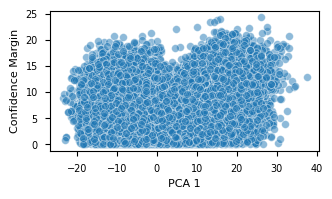

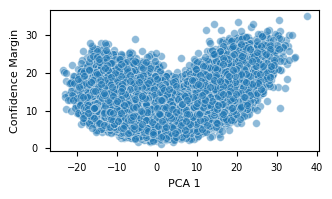

In [6]:
from sklearn.decomposition import PCA

def get_pca(logits: np.ndarray, n_components: int) -> np.array:
    """
    Get the PCA of target model's logits on the target data
    """
    pca = PCA(n_components=n_components)
    pca.fit(logits)
    return pca

def get_logits(model, data, device) -> np.array:
    """
    Get the confidence scores of the model on each data point
    """
    model.eval()
    model.to(device)

    data_loader = torch.utils.data.DataLoader(data, batch_size=512, shuffle=False)
    logits = None
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).cpu().numpy()
            logits = outputs if logits is None else np.concatenate([logits, outputs], axis=0)
    return logits

if os.path.exists(f"{output_dir}/logits.pkl"):
    logits = pickle.load(open(f"{output_dir}/logits.pkl", "rb"))
else:
    logits = np.concatenate([get_logits(target_model, target_dataset.target_trainset, "cuda:0"),
                             get_logits(target_model, target_dataset.target_testset, "cuda:0")])
    pickle.dump(logits, open(f"{output_dir}/logits.pkl", "wb"))

logits_pca = get_pca(logits, 3)

def plot_scatter(conf_margin, pca):
    """
    use sns to plot the scatter plot of the data
    """
    plt.figure(figsize=(COLUMNWIDTH_INCH, 2))
    sns.scatterplot(x=pca[:, 0], y=conf_margin, alpha=0.5)
    plt.xlabel("PCA 1")
    plt.ylabel("Confidence Margin")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/pca_conf_margin.pdf", format='pdf')

plot_scatter(max_posterior_diff_with_second, logits_pca.transform(logits))
plot_scatter(max_posterior_diff_with_rest, logits_pca.transform(logits))